## **Functions**

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import random
from statsmodels.stats.power import TTestIndPower
from collections import Counter

In [ ]:
def create_dataset2(size,percentage_alc_only, percentage_dep_only, percentage_tobacco_only,percentage_alc_dep, percentage_alc_tobacco,percentage_dep_tobacco, 
                    percentage_tobacco_alcoholism_depression,treatment_noth,treatment_1_conditions,treatment_2_conditions,treatment_3_conditions,
                    gender,bmi,edu,seed,age=[18,60,35,15]):
  """
  User Defined Inputs:
  1.size=Population Sample size
  2.percentage_alcoholism/depression/tobacco=Percentage of the the respective condition in the population
  3.percentage_alcoholism_depression(and other dual variable overlaps)= Percentage of the overlap of respective two condtions in the populations
  4.percentage_tobacco_alcoholism_depression= Percentage of the overlap of all 3 cases in the population
  5.gender, bmi, edu: A list consisting of the percentages of distribution in the various categorical buckets for the following variables:
  eg;  
  buckets; gender: 2 buckets; bmi: 3 buckets; edu: 4 buckets
  6.age has 4 parameters - a_min, a_max, mean, std dev
  6.Treatment_noth/treatment_1_conditions=The percentage of good treatment outcomes for the population with the following number of conditions
  """
  zeros=1-(percentage_alc_only + percentage_dep_only  + percentage_tobacco_only + percentage_alc_dep + percentage_alc_tobacco + percentage_dep_tobacco + percentage_tobacco_alcoholism_depression)
  
  print("zeros:{}".format(zeros))
  np.random.seed(2020)
  condition=np.random.choice(8,size,p=[zeros, percentage_alc_only, percentage_dep_only,percentage_alc_dep,percentage_tobacco_only,percentage_alc_tobacco, percentage_dep_tobacco, percentage_tobacco_alcoholism_depression])
  alcoholism=np.where((condition == 1) | (condition==3) | (condition==5) | (condition==7),1,0)
  depression=np.where((condition == 2) | (condition==3) | (condition==6) | (condition==7),1,0)
  
  alc_only=np.where(condition == 1,1,0)
  dep_only=np.where(condition == 2,1,0)
  tobacco_only=np.where(condition == 4,1,0)

  alc_dep=np.where(condition == 3,1,0)
  alc_tobacco=np.where(condition == 5,1,0)
  dep_tobacco=np.where(condition == 6,1,0)

  tobacco=np.where((condition == 4) | (condition==5) | (condition==6) | (condition==7),1,0)
  all_three=np.where(condition == 7,1,0)
  age_1= np.random.normal(loc=age[2], scale=age[3], size=size)
  age_1=np.clip(age_1, a_min=age[0], a_max=age[1])
  age_1 = np.round(age_1).astype(int)
  sex=np.random.choice(2,size,p=[gender[0],gender[1]])
  body_mass=np.random.choice(3,size,p=[bmi[0],bmi[1],bmi[2]])
  education=np.random.choice(4,size,p=[edu[0],edu[1],edu[2],edu[3]])
  cavitation = np.random.choice(2,size,p=[0.5,0.5])
  ttd = np.random.normal(loc=7, scale=3, size=size)
  df = pd.DataFrame(
    {
        'idx': np.arange(1, size+1),
        'age': age_1,
        'gender': sex,
        'bmi': body_mass,
        'education': education,
        'cavitation': cavitation,
      	'TTD': ttd,
        'alcoholism': alcoholism,
        'depression': depression,
        'tobacco': tobacco,
        'alcohol_only':alc_only,
        'depression_only':dep_only,
        'tobacco_only': tobacco_only,
        'alcoholism+depression':alc_dep,
        'alcoholism+tobacco':alc_tobacco,
        'depression+tobacco':dep_tobacco,
        'tobacco+alcohol+smoking':all_three
     }
  )
  intervention_arr=[]
  choices_alc_only=['NAlc','A']
  choices_dep_only=['ND','D']
  choices_tobacco_only=['NT','T']
  choices_alc_dep_only=['NAD','AD']
  choices_alc_tobacco_only=['NAT','AT']
  choices_dep_tobacco_only=['NDT','DT']
  choices_all_3=['NADT','ADT']
  random.seed(seed)
  weights=[0.5,0.5]
  for i in range(size):
    if(df['alcohol_only'][i]==1):
      #intervention_arr.append(np.random.binomial(1,0.5,size=1))
      intervention_arr.append(random.choices(choices_alc_only,weights=weights)[0])
    if(df['depression_only'][i]==1):
      intervention_arr.append(random.choices(choices_dep_only,weights=weights)[0])
    if(df['tobacco_only'][i]==1):
      intervention_arr.append(random.choices(choices_tobacco_only,weights=weights)[0])
    if(df['alcoholism+depression'][i]==1):
      intervention_arr.append(random.choices(choices_alc_dep_only,weights=weights)[0])
    if(df['alcoholism+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_alc_tobacco_only,weights=weights)[0])
    if(df['depression+tobacco'][i]==1):
      intervention_arr.append(random.choices(choices_dep_tobacco_only,weights=weights)[0])
    if(df['tobacco+alcohol+smoking'][i]==1):
      intervention_arr.append(random.choices(choices_all_3,weights=weights)[0])
    if(df['alcoholism'][i]==0 and df['depression'][i]==0 and df['tobacco'][i]==0):
      intervention_arr.append('UNAFFECTED')
  df['Intervention'] = intervention_arr
  #print(np.unique(intervention_arr,return_councentage_ts=True))
  df['treatment_outcomes'] = " "
  treatment_outcomes_single_ni = []
  treatment_outcomes_two_ni = []
  treatment_outcomes_three_ni = []
  treatment_outcomes_i = []
  #treatment_outcomes_noth = []

  list_noth = list(np.where(df['Intervention'] == 'UNAFFECTED')[0])
  values_noth = np.random.choice(2,len(list_noth),p=[1-treatment_noth,treatment_noth])
  for i in range(len(list_noth)):
    df.loc[list_noth[i],"treatment_outcomes"] = values_noth[i]
  
  list_single_ni = list(np.where((df['Intervention'] == 'NAlc') | (df['Intervention'] == 'ND') | (df['Intervention'] == 'NT'))[0])
  values_single_ni = np.random.choice(2,len(list_single_ni),p=[1-treatment_1_conditions,treatment_1_conditions])
  for i in range(len(list_single_ni)):
    df.loc[list_single_ni[i],"treatment_outcomes"] = values_single_ni[i]

  list_two_ni = list(np.where((df['Intervention'] == 'NAD') | (df['Intervention'] == 'NDT') | (df['Intervention'] == 'NAT'))[0])
  values_two_ni = np.random.choice(2,len(list_two_ni),p=[1-treatment_2_conditions,treatment_2_conditions])
  for i in range(len(list_two_ni)):
    df.loc[list_two_ni[i],"treatment_outcomes"] = values_two_ni[i]

  list_three_ni = list(np.where(df['Intervention'] == 'NADT')[0])
  values_three_ni = np.random.choice(2,len(list_three_ni),p=[1-treatment_3_conditions,treatment_3_conditions])
  for i in range(len(list_three_ni)):
    df.loc[list_three_ni[i],"treatment_outcomes"] = values_three_ni[i]

  #list_i = list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'D') | (df['Intervention'] == 'T') | (df['Intervention'] == 'AD') | (df['Intervention'] == 'AT') | (df['Intervention'] == 'DT') | (df['Intervention'] == 'ADT'))[0])
  #values_i = np.random.choice(2,len(list_i),p=[1-treatment_intervention,treatment_intervention])
  #for i in range(len(list_i)):
   # df.loc[list_i[i],"treatment_outcomes"] = values_i[i]
  
  list_single_inter=list(np.where((df['Intervention'] == 'A') | (df['Intervention'] == 'D') | (df['Intervention'] == 'T'))[0])
  s_int=(1-treatment_1_conditions)/2
  values_single_inter = np.random.choice(2,len(list_single_inter),p=[s_int,treatment_1_conditions+s_int])
  for i in range(len(list_single_inter)):
    df.loc[list_single_inter[i],"treatment_outcomes"] = values_single_inter[i]

  list_double_inter=list(np.where((df['Intervention'] == 'AD') | (df['Intervention'] == 'DT') | (df['Intervention'] == 'AT'))[0])
  d_int=(1-treatment_2_conditions)/2
  values_double_inter = np.random.choice(2,len(list_double_inter),p=[d_int,treatment_2_conditions + d_int])
  for i in range(len(list_double_inter)):
    df.loc[list_double_inter[i],"treatment_outcomes"] = values_double_inter[i]

  list_triple_inter=list(np.where((df['Intervention'] == 'ADT'))[0])
  t_int = (1-treatment_3_conditions)/2
  values_triple_inter = np.random.choice(2,len(list_triple_inter),p=[t_int,treatment_3_conditions+ t_int])
  for i in range(len(list_triple_inter)):
    df.loc[list_triple_inter[i],"treatment_outcomes"] = values_triple_inter[i]

  return df


In [ ]:
dataset = create_dataset2(10000,0.12,0.12,0.12,0.08,0.08,0.08,0.04,0.9,0.80,0.70,0.60,gender=[0.5,0.5],bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52,age=[18,60,35,15])
dataset.head()

zeros:0.36


,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,alcohol_only,depression_only,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes
0,1,46,0,2,3,0,10.303239,1,1,1,0,0,0,0,0,0,1,ADT,1
1,2,25,0,2,3,0,3.024776,1,0,1,0,0,0,0,1,0,0,NAT,1
2,3,32,0,2,3,0,9.150407,0,1,0,0,1,0,0,0,0,0,D,1
3,4,27,0,2,1,1,6.769593,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,1
4,5,43,0,1,0,0,6.976852,0,0,0,0,0,0,0,0,0,0,UNAFFECTED,1


In [ ]:
ratio_alc_only = dataset['Intervention'].value_counts(normalize=True)['A']+dataset['Intervention'].value_counts(normalize=True)['NAlc']
ratio_alc_only

0.1163

In [ ]:
power_analysis=TTestIndPower()
def calculate_power(x, y, df):
    power_analysis=TTestIndPower()
    treatment_arr=[]
    control_arr=[]
    treatment_locs=np.where((df['Intervention']==x))
    control_locs=np.where((df['Intervention']==y))
    for i in treatment_locs:
        treatment_arr.append(df['treatment_outcomes'].iloc[i])
    for j in control_locs:
        control_arr.append(df['treatment_outcomes'].iloc[j])
    l1 = len(treatment_arr[0])
    l2 = len(control_arr[0])
    index_treatment=np.arange(0,l1)
    index_control=np.arange(0,l2)
    treatment_df=pd.DataFrame({'idx':index_treatment,"Treatment":treatment_arr[0]})
    control_df=pd.DataFrame({'idx':index_control,"Control":control_arr[0]}) 
    mu1=treatment_df['Treatment'].mean()
    mu2=control_df['Control'].mean()
    std1=treatment_df['Treatment'].std()
    std2=control_df['Control'].std()
    s = np.sqrt(((l1 - 1) * std1 + (l2 - 1) * std2) / (l1 + l2 - 2))
    d = (mu1 - mu2) / s #cohen's effect size
    eff = round(d,2)
    p = power_analysis.power(effect_size=eff,alpha=0.05,nobs1=l1,ratio=(l1/l2),alternative='two-sided')
    return p

In [ ]:
def check_sample_sizes(dfx):
  sample_sizes={}
  sample_sizes['Alcohol']=calculate_power('A','NAlc',dfx)
  sample_sizes['Depression']=calculate_power('D','ND',dfx)  
  sample_sizes['Tobacco']=calculate_power('T','NT',dfx)  
  sample_sizes['Alcohol-Depression']=calculate_power('AD','NAD',dfx)  
  sample_sizes['Alcohol-Tobacco']=calculate_power('AT','NAT',dfx)  
  sample_sizes['Depression-Tobacco']=calculate_power('DT','NDT',dfx) 
  sample_sizes['Alcohol-Depression-Tobacco']=calculate_power('ADT','NADT',dfx) 
  #for i in sample_sizes.values():
  all_above_threshold = all(value >= 0.8 for value in sample_sizes.values())
  print(all_above_threshold)
  print(sample_sizes.values())
  return sample_sizes.values
# check_sample_sizes(df_2)


### **NEW APPROACH FOR Calculating Sample size and creating Clinical Dataset from it...**

In [ ]:
# def try_sample_sizes4(dfx):
#     sample_sizes = {}
#     sample_sizes['Alcohol'] = calculate_power('A', 'NAlc', dfx)
#     sample_sizes['Depression'] = calculate_power('D', 'ND', dfx)
#     sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
#     sample_sizes['Alcohol-Depression'] = calculate_power('AD', 'NAD', dfx)
#     sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
#     sample_sizes['Depression-Tobacco'] = calculate_power('DT', 'NDT', dfx)
#     sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('ADT', 'NADT', dfx)

#     size = dfx.shape[0]
#     #total_power = sum(sample_sizes.values())
#     all_above_threshold = all(value >= 0.75 for value in sample_sizes.values())
#     if not all_above_threshold:
#         if sample_sizes['Alcohol'] < 0.75:
#             size += 100
#         elif sample_sizes['Depression'] < 0.75:
#             size += 100
#         elif sample_sizes['Tobacco'] < 0.75:
#             size += 100
#         elif sample_sizes['Alcohol-Depression'] < 0.75:
#             size += 80
#         elif sample_sizes['Alcohol-Tobacco'] < 0.75:
#             size += 80
#         elif sample_sizes['Depression-Tobacco'] < 0.75:
#             size += 80
#         elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.75:
#             size += 20

#         dfx = create_dataset2(size, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, 0.90, age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2, 0.5, 0.3], edu=[0.1, 0.2, 0.2, 0.5], seed=52)
#         return try_sample_sizes4(dfx)


#       dfx = create_dataset2(size, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, 0.90, age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
#       return try_sample_sizes4(dfx)
#     return dfx


def try_sample_sizes4(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NAlc', dfx)
    sample_sizes['Depression'] = calculate_power('D', 'ND', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AD', 'NAD', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('DT', 'NDT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('ADT', 'NADT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.75 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.75:
            size += 100
        elif sample_sizes['Depression'] < 0.75:
            size += 100
        elif sample_sizes['Tobacco'] < 0.75:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.75:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.75:
            size += 20

        ratio_alc_only = dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NAlc']
        ratio_dep_only = dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND']
        ratio_tob_only = dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT']
        ratio_at = dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT']
        ratio_ad = dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD']
        ratio_dt = dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT']
        ratio_adt = dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT']

        dfx =  create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes4(dfx)

    for group in sample_sizes.keys():
       print('inside shrinking')
       while all(value > 0.85 for value in sample_sizes.values()):
            if sample_sizes[group] > 0.95:
                size -= 1500
            #if any(value < 0.80 for value in sample_sizes.values()):
            ratio_alc_only = dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NAlc']
            ratio_dep_only = dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND']
            ratio_tob_only = dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT']
            ratio_at = dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT']
            ratio_ad = dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD']
            ratio_dt = dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT']
            ratio_adt = dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT']
            #print('a',ratio_alc_only)
            dfx = create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            return try_sample_sizes4(dfx)
    return dfx

In [ ]:
def try_sample_sizes4(dfx):
    sample_sizes = {}
    sample_sizes['Alcohol'] = calculate_power('A', 'NAlc', dfx)
    sample_sizes['Depression'] = calculate_power('D', 'ND', dfx)
    sample_sizes['Tobacco'] = calculate_power('T', 'NT', dfx)
    sample_sizes['Alcohol-Depression'] = calculate_power('AD', 'NAD', dfx)
    sample_sizes['Alcohol-Tobacco'] = calculate_power('AT', 'NAT', dfx)
    sample_sizes['Depression-Tobacco'] = calculate_power('DT', 'NDT', dfx)
    sample_sizes['Alcohol-Depression-Tobacco'] = calculate_power('ADT', 'NADT', dfx)

    size = dfx.shape[0]
    #total_power = sum(sample_sizes.values())
    all_above_threshold = all(value >= 0.79 for value in sample_sizes.values())
    if not all_above_threshold:
        if sample_sizes['Alcohol'] < 0.79:
            size += 100
        elif sample_sizes['Depression'] < 0.79:
            size += 100
        elif sample_sizes['Tobacco'] < 0.79:
            size += 100
        elif sample_sizes['Alcohol-Depression'] < 0.79:
            size += 80
        elif sample_sizes['Alcohol-Tobacco'] < 0.79:
            size += 80
        elif sample_sizes['Depression-Tobacco'] < 0.79:
            size += 80
        elif sample_sizes['Alcohol-Depression-Tobacco'] < 0.79:
            size += 20
          
        ratio_alc_only = round(dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NAlc'],2)
        ratio_dep_only = round(dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND'],2)
        ratio_tob_only = round(dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT'],2)
        ratio_at = round(dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT'],2)
        ratio_ad = round(dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD'],2)
        ratio_dt = round(dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT'],2)
        ratio_adt = round(dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT'],2)
        
        #dfx = create_dataset2(size, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        dfx = create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
        return try_sample_sizes4(dfx)
    for group in sample_sizes.keys():
       print('inside shrinking')
       while all(value > 0.85 for value in sample_sizes.values()):
            if sample_sizes[group] > 0.95:
                if size<30000:
                  size -= 1500
                else:
                  size-=1000
            #if any(value < 0.80 for value in sample_sizes.values()):
            
            ratio_alc_only = round(dfx['Intervention'].value_counts(normalize=True)['A']+dfx['Intervention'].value_counts(normalize=True)['NAlc'],2)
            ratio_dep_only = round(dfx['Intervention'].value_counts(normalize=True)['D']+dfx['Intervention'].value_counts(normalize=True)['ND'],2)
            ratio_tob_only = round(dfx['Intervention'].value_counts(normalize=True)['T']+dfx['Intervention'].value_counts(normalize=True)['NT'],2)
            ratio_at = round(dfx['Intervention'].value_counts(normalize=True)['AT']+dfx['Intervention'].value_counts(normalize=True)['NAT'],2)
            ratio_ad = round(dfx['Intervention'].value_counts(normalize=True)['AD']+dfx['Intervention'].value_counts(normalize=True)['NAD'],2)
            ratio_dt = round(dfx['Intervention'].value_counts(normalize=True)['DT']+dfx['Intervention'].value_counts(normalize=True)['NDT'],2)
            ratio_adt = round(dfx['Intervention'].value_counts(normalize=True)['ADT']+dfx['Intervention'].value_counts(normalize=True)['NADT'],2)
                
            dfx = create_dataset2(size, ratio_alc_only, ratio_dep_only, ratio_tob_only, ratio_ad, ratio_at, ratio_dt, ratio_adt, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            #dfx = create_dataset2(size, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
            return try_sample_sizes4(dfx)
    return dfx

In [ ]:
df2 = create_dataset2(30000, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60, gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)

zeros:0.6100000000000001


In [ ]:
ratio_alc_only = df2['Intervention'].value_counts(normalize=True)['AT']+df2['Intervention'].value_counts(normalize=True)['NAT']
round(ratio_alc_only,2)


0.04

In [ ]:
df_ss4 =try_sample_sizes4(df2)
check_sample_sizes(df_ss4) 
df_ss4.shape[0]

inside shrinking
zeros:0.6100000000000001
inside shrinking
zeros:0.6100000000000001
inside shrinking
zeros:0.6100000000000001
inside shrinking
zeros:0.6100000000000001
zeros:0.6100000000000001
inside shrinking
zeros:0.6100000000000001
inside shrinking
zeros:0.6100000000000001
zeros:0.6100000000000001
zeros:0.6100000000000001
zeros:0.6100000000000001
zeros:0.6100000000000001
zeros:0.6100000000000001
inside shrinking
inside shrinking
inside shrinking
inside shrinking
inside shrinking
inside shrinking
inside shrinking
True
dict_values([0.9490931862355432, 0.8457592008526247, 0.9896941891849261, 0.826085149049147, 0.9691353039863176, 0.8744989523845637, 0.8801332677404644])


22040

df3 = create_dataset2(40000, 0.08, 0.08, 0.08, 0.04, 0.04, 0.04, 0.03, 0.9, 0.80, 0.70, 0.60,age=[0.3, 0.4, 0.3], gender=[0.5, 0.5], bmi=[0.2,0.5,0.3],edu=[0.1,0.2,0.2,0.5],seed=52)
df_ss3 =try_sample_sizes4(df3)
check_sample_sizes(df_ss3) 
df_ss3.shape[0]

In [ ]:
df_ss4['Intervention'].value_counts()

UNAFFECTED    13556
T               900
D               895
A               877
ND              873
NT              871
NA              840
NAT             448
NAD             444
AT              439
DT              437
NDT             433
AD              402
NADT            323
ADT             302
Name: Intervention, dtype: int64

In [ ]:
counts= df_ss4['Intervention'].value_counts()[1]
counts

900

In [ ]:
max_unaffected= df_ss4['Intervention'].value_counts()[0]
max_unaffected

13556

In [ ]:
column_name = 'Intervention'

condition = df_ss4[column_name] == 'UNAFFECTED'
selected_rows = df_ss4[condition]

new_value = 'unaffected'
count_to_reduce = max_unaffected - (max_unaffected-counts)
count_reduced = 0

for index, row in selected_rows.iterrows():
    if count_reduced < count_to_reduce:
        df_ss4.at[index, column_name] = new_value
        count_reduced += 1
    else:
        break
df_ss4['Intervention'].value_counts()

UNAFFECTED    12656
unaffected      900
T               900
D               895
A               877
ND              873
NT              871
NA              840
NAT             448
NAD             444
AT              439
DT              437
NDT             433
AD              402
NADT            323
ADT             302
Name: Intervention, dtype: int64

In [ ]:
condition = df_ss4['Intervention'] != 'UNAFFECTED'
clinical = df_ss4[condition]

clinical = clinical.dropna()

# print(clinical.head())
clinical['Intervention'].value_counts()


unaffected    900
T             900
D             895
A             877
ND            873
NT            871
NA            840
NAT           448
NAD           444
AT            439
DT            437
NDT           433
AD            402
NADT          323
ADT           302
Name: Intervention, dtype: int64

In [ ]:
clinical.head()

,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,alcohol_only,depression_only,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes
0,1,60,1,2,2,1,2.891832,1,1,1,0,0,0,0,0,0,1,ADT,0
1,2,40,1,2,2,0,2.848100,0,0,1,0,0,1,0,0,0,0,NT,0
2,3,54,1,1,1,1,4.189519,0,0,0,0,0,0,0,0,0,0,unaffected,1
3,4,60,1,1,3,0,3.812965,0,0,0,0,0,0,0,0,0,0,unaffected,1
4,5,41,0,2,3,0,10.048421,0,0,0,0,0,0,0,0,0,0,unaffected,1


In [ ]:
def clinical_ss(dfx):
  counts= dfx['Intervention'].value_counts()[1]

  max_unaffected= dfx['Intervention'].value_counts()[0]
  column_name = 'Intervention'

  condition = dfx[column_name] == 'UNAFFECTED'
  selected_rows = dfx[condition]

  new_value = 'unaffected'
  count_to_reduce = max_unaffected - (max_unaffected-counts)
  count_reduced = 0

  for index, row in selected_rows.iterrows():
      if count_reduced < count_to_reduce:
          dfx.at[index, column_name] = new_value
          count_reduced += 1
      else:
          break
  condition = dfx['Intervention'] != 'UNAFFECTED'
  clinical = dfx[condition]

  clinical = clinical.dropna()
  return clinical


In [ ]:
clinical_trial= clinical_ss(df_ss4)

In [ ]:
clinical_trial

,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,alcohol_only,depression_only,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes
0,1,60,1,2,2,1,2.891832,1,1,1,0,0,0,0,0,0,1,ADT,0
1,2,40,1,2,2,0,2.848100,0,0,1,0,0,1,0,0,0,0,NT,0
2,3,54,1,1,1,1,4.189519,0,0,0,0,0,0,0,0,0,0,unaffected,1
3,4,60,1,1,3,0,3.812965,0,0,0,0,0,0,0,0,0,0,unaffected,1
4,5,41,0,2,3,0,10.048421,0,0,0,0,0,0,0,0,0,0,unaffected,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22021,22022,29,0,2,1,1,4.341764,0,0,1,0,0,1,0,0,0,0,NT,0
22025,22026,42,1,2,3,1,3.529521,0,0,1,0,0,1,0,0,0,0,NT,1
22027,22028,44,0,0,3,0,1.455767,0,1,0,0,1,0,0,0,0,0,ND,1
22029,22030,60,1,1,2,1,9.552300,0,1,0,0,1,0,0,0,0,0,D,1


In [ ]:
clinical_trial.shape[0]

10284

In [ ]:
df_ss4['treatment_outcomes'].value_counts(normalize=True)

1    0.86951
0    0.13049
Name: treatment_outcomes, dtype: float64

In [ ]:
clinical_trial['treatment_outcomes'].value_counts(normalize=True)

1    0.830124
0    0.169876
Name: treatment_outcomes, dtype: float64

In [ ]:
clinical_trial.head()

,idx,age,gender,bmi,education,cavitation,TTD,alcoholism,depression,tobacco,alcohol_only,depression_only,tobacco_only,alcoholism+depression,alcoholism+tobacco,depression+tobacco,tobacco+alcohol+smoking,Intervention,treatment_outcomes
0,1,60,1,2,2,1,2.891832,1,1,1,0,0,0,0,0,0,1,ADT,0
1,2,40,1,2,2,0,2.848100,0,0,1,0,0,1,0,0,0,0,NT,0
2,3,54,1,1,1,1,4.189519,0,0,0,0,0,0,0,0,0,0,unaffected,1
3,4,60,1,1,3,0,3.812965,0,0,0,0,0,0,0,0,0,0,unaffected,1
4,5,41,0,2,3,0,10.048421,0,0,0,0,0,0,0,0,0,0,unaffected,1


In [ ]:
clinical_trial.to_csv('clinical_trial_data.csv')

In [ ]:
def power_curves(x,y,df):
 """ x = value of treatment variable (gives us idea of the population - NAlc, a, nt, t, adt, etc)
    y = value of control variable """
 if len(x)==1:
   eff=0.10
 if len(x)==2:
   eff=0.20
 if len(x)==3:
   eff=0.30
 treatment_arr=[]
 control_arr=[]
 treatment_locs=np.where((df['Intervention']==x))
 control_locs=np.where((df['Intervention']==y))
 for i in treatment_locs:
     treatment_arr.append(df['treatment_outcomes'].iloc[i])
 for j in control_locs:
     control_arr.append(df['treatment_outcomes'].iloc[j])
 l1 = len(treatment_arr[0])
 l2 = len(control_arr[0])
 
 power_analysis.plot_power(dep_var='nobs',nobs=np.arange(5, l1+l2),
                          effect_size=np.array([eff,eff-0.02,eff-0.03]),
                          alpha=0.05)
 


The required sample size for the power of 0.8= 544.1357679461363
The current statistical power is 0.9869408410453885


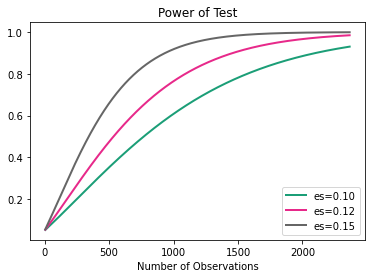

In [ ]:
power_curves('A','NAlc',df2)

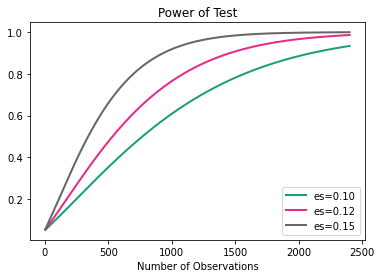

In [ ]:
power_curves('T','NT',df2)

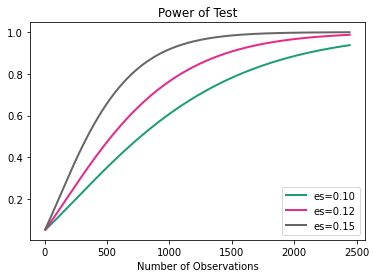

In [ ]:
power_curves('D','ND',df2)

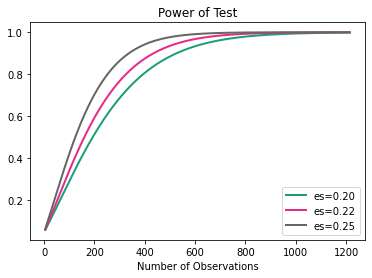

In [ ]:
power_curves('AT','NAT',df2)

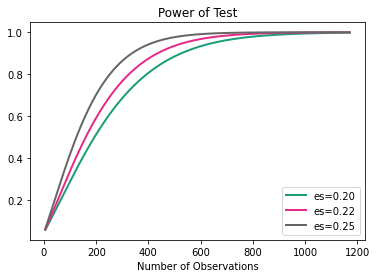

In [ ]:
power_curves('AD','NAD',df2)

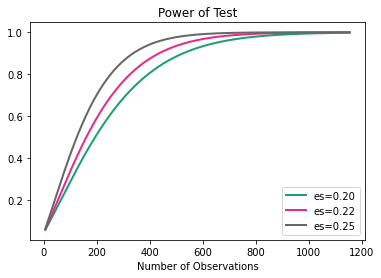

In [ ]:
power_curves('DT','NDT',df2)

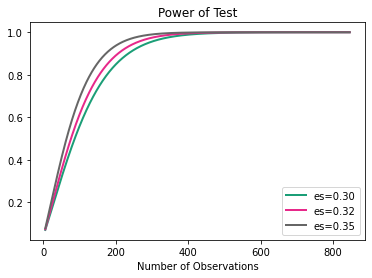

In [ ]:
power_curves('ADT','NADT',df2)